###### Transformation Equations:  GALEX NUV, SDSS g, GAIA EDR3 --> SDSS u

_Douglas L. Tucker_

_2021.06.18_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [2]:
# Order of polynomial fits...
norder = 2

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# Identify directory containing the DES/SDSS match file...
matchDir = '/data/des40.a/data/dtucker/SDSS'

# Name of the DES/SDSS match file in matchDir
#matchFile = 'SDSSDR16_lt_10_dtucker_galex_gaiaedr3.fit'
matchFile = 'SDSSDR16_dtucker_all_sorted.fit'

# Base name of fit results output file...
resultsFileBaseName = 'transFit.galex_sdss_u'

# Base name of QA plot output files...
qaFileBaseName = 'qaPlot.galex_sdss_u.fit'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [3]:
##################################
#
# Define some functions for fitting dmag vs. color...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp1, we assume a polynomial function in one color...
def fp1(p,color1_array):
    #retValue = p[0] + p[1]*color1_array + p[2]*color1_array*color1_array
    norder = p.size-1
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
    return retValue


##################################

# Error function:
def residuals1(p,color1_array,dmag_array):
    err = (dmag_array-fp1(p,color1_array))
    return err


##################################

# Fitting code:
def transformFit1(color1_array, dmag_array, norder=2, verbose=0):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2'])
    pname = []
    for i in range(0,norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0]
    p0 = (1+norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals1, p0, 
                                      args=(color1_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0:  print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:  
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:  
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms


In [4]:
##################################
#
# Define some functions for fitting dmag vs. color1 and color2...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp2, we assume a polynomial in each of the 2 colors 
#   but with no cross terms... 
def fp2(p,color1_array,color2_array):
    #retValue = p[0] + \
    #    p[1]*color1_array + p[2]*color1_array*color1_array + \
    #    p[3]*color2_array + p[4]*color2_array*color2_array
    norder = (p.size-1)/2
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
        retValue = retValue + p[i+norder+1]*color2_array**(i+1)
    return retValue


##################################

# Error function:
def residuals2(p,color1_array,color2_array,dmag_array):
    err = (dmag_array-fp2(p,color1_array,color2_array))
    return err


##################################

# Fitting code:
def transformFit2(color1_array, color2_array, dmag_array, norder=2, verbose=0):
    
    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2', 'c_3', 'c_4'])
    pname = []
    for i in range(0,2*norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0, 0.0, 0.0]
    p0 = (1+2*norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0


    # Perform fit
    p,cov,infodict,mesg,ier = leastsq(residuals2, p0, 
                                      args=(color1_array, color2_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0: print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms



In [5]:
##################################
#
# Define some functions for fitting dmag vs. color1, color2, and abs(Galactic Latitude)...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp2, we assume a polynomial in each of the 2 colors 
#   but with no cross terms... 
def fp2glat(p,color1_array,color2_array,abs_glat_array):
    #retValue = p[0] + \
    #    p[1]*color1_array + p[2]*color1_array*color1_array + \
    #    p[3]*color2_array + p[4]*color2_array*color2_array + \
    #    p[4]*abs_glat_array
    norder = (p.size-2)/2
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
        retValue = retValue + p[i+norder+1]*color2_array**(i+1)
    retValue = retValue + p[p.size-1]*abs_glat_array 
    return retValue


##################################

# Error function:
def residuals2glat(p,color1_array,color2_array,abs_glat_array,dmag_array):
    err = (dmag_array-fp2glat(p,color1_array,color2_array,abs_glat_array))
    return err


##################################

# Fitting code:
def transformFit2glat(color1_array, color2_array, abs_glat_array, dmag_array, norder=2, verbose=0):
    
    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2', 'c_3', 'c_4'])
    pname = []
    for i in range(0,2*norder+2):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0, 0.0, 0.0]
    p0 = (2+2*norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0


    # Perform fit
    p,cov,infodict,mesg,ier = leastsq(residuals2, p0, 
                                      args=(color1_array, color2_array, abs_glat_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0: print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms



In [6]:
##################################

def createFitResultsOutputLine(norder, p, perr, rms, dmag_name, color1_name, color2_name=''):

    outputList = (2*(2*norder+1)+4)*[-9999.]
    outputList[0] = dmag_name
    outputList[1] = color1_name
    outputList[2] = color2_name
    for j in range(p.size):
        outputList[2*j+3] = p[j]
        outputList[2*j+4] = perr[j]
    outputList[2*(2*norder+1)+3] = rms
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine(norder):

    outputList = (2*(2*norder+1)+4)*['c_']
    outputList[0] = 'dmag_name'
    outputList[1] = 'color1_name'
    outputList[2] = 'color2_name'
    for j in range(2*norder+1):
        outputList[2*j+3] = ("""c_%d""" % j)
        outputList[2*j+4] = ("""cerr_%d""" % j)
    outputList[2*(2*norder+1)+3] = 'rms'
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def transform1ColorQAPlots1(dmag, color1, res, norder, title, dmagName, colorLabel1, p, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    if norder == 1:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    elif norder == 2:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    else:
        plot1Text = ''
    #plt.text(0.1,0.25,plot1Text)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

def transform2ColorQAPlots1(dmag, color1, color2, res, norder, dmagName, colorLabel1, colorLabel2, p, rms, outputFileName):

    # Prepare QA plots...
    fig = plt.figure(figsize=(10,5))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")

    # We will exclude the lowest and highets 1% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.01, 0.99])
    color2_desc = color2.describe(percentiles=[0.01, 0.99])
    dmag_desc = dmag.describe(percentiles=[0.01, 0.99])
    #res_desc = df.res.describe(percentiles=[0.01, 0.99])
    res_desc = res.describe(percentiles=[0.01, 0.99])
    color1_min = color1_desc['1%']
    color1_max = color1_desc['99%']
    color2_min = color2_desc['1%']
    color2_max = color2_desc['99%']
    dmag_min = dmag_desc['1%']
    dmag_max = dmag_desc['99%']
    res_min = res_desc['1%']
    res_max = res_desc['99%']

    # Plot 1:  Descriptive text...
    plt.subplot(231)
    if norder == 1:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorLabel1, p[2], colorLabel2, rms)
    elif norder == 2:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, p[3], colorLabel2, p[4], colorLabel2, rms)
    else:
        plot1Text = ''
    plt.text(0.1,0.25,plot1Text)
    plt.axis('off')

    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(232) 
    hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 3:  2D hexbin histogram of dmag vs. color2...
    plt.subplot(233) 
    hb=plt.hexbin(color2, dmag, gridsize=100, cmap='inferno')
    plt.axis([color2_min, color2_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel2)
    plt.ylabel(dmagName)
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 4:  1d histogram of residuals...
    plt.subplot(234) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    # Plot 5:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(235) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot 6:  2d hexbin histogram of residuals vs. color2...
    plt.subplot(236) 
    #hb = plt.hexbin(color2, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color2, res, gridsize=100, cmap='inferno')
    plt.axis([color2_min, color2_max, res_min, res_max])
    plt.xlabel(colorLabel2)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

def transform2ColorQAPlots1glat(dmag, color1, color2, absglat, res, norder, dmagName, colorLabel1, colorLabel2, absglatLabel, p, rms, outputFileName):

    # Prepare QA plots...
    fig = plt.figure(figsize=(10,5))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")

    # We will exclude the lowest and highets 1% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.01, 0.99])
    color2_desc = color2.describe(percentiles=[0.01, 0.99])
    dmag_desc = dmag.describe(percentiles=[0.01, 0.99])
    #res_desc = df.res.describe(percentiles=[0.01, 0.99])
    res_desc = res.describe(percentiles=[0.01, 0.99])
    color1_min = color1_desc['1%']
    color1_max = color1_desc['99%']
    color2_min = color2_desc['1%']
    color2_max = color2_desc['99%']
    dmag_min = dmag_desc['1%']
    dmag_max = dmag_desc['99%']
    res_min = res_desc['1%']
    res_max = res_desc['99%']

    # Plot 1:  Descriptive text...
    plt.subplot(231)
    if norder == 1:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorLabel1, p[2], colorLabel2, rms)
    elif norder == 2:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, p[3], colorLabel2, p[4], colorLabel2, rms)
    else:
        plot1Text = ''
    plt.text(0.1,0.25,plot1Text)
    plt.axis('off')

    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(232) 
    hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 3:  2D hexbin histogram of dmag vs. color2...
    plt.subplot(233) 
    hb=plt.hexbin(color2, dmag, gridsize=100, cmap='inferno')
    plt.axis([color2_min, color2_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel2)
    plt.ylabel(dmagName)
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 4:  1d histogram of residuals...
    plt.subplot(234) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    # Plot 5:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(235) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot 6:  2d hexbin histogram of residuals vs. color2...
    plt.subplot(236) 
    #hb = plt.hexbin(color2, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color2, res, gridsize=100, cmap='inferno')
    plt.axis([color2_min, color2_max, res_min, res_max])
    plt.xlabel(colorLabel2)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

def createFitResultsOutputLine_a(norder, p, perr, rms, \
                                 mag_name, mag_name_match, \
                                 color1_name, color1_min, color1_max, \
                                 color2_name='', color2_min=-9999., color2_max=+9999.):

    #Formatting assumes ncolor=2
    # If ncolor=1, blanks or signal values are used for 
    # the color2 info.
    ncolor = 2
    outputList = (5+3*ncolor + 2*(ncolor*norder))*[-9999.]
    
    #outputList = (2*(2*norder+1)+8)*[-9999.]
    outputList[0] = mag_name
    outputList[1] = mag_name_match
    outputList[2] = color1_name
    outputList[3] = color2_name
    for j in range(p.size):
        outputList[2*j+4] = p[j]
        outputList[2*j+5] = perr[j]
    outputList[2*(2*norder+1)+4] = rms
    outputList[2*(2*norder+1)+5] = color1_min
    outputList[2*(2*norder+1)+6] = color1_max
    outputList[2*(2*norder+1)+7] = color2_min
    outputList[2*(2*norder+1)+8] = color2_max
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine_a(norder, ncolor=2):

    #ncolor=1
    #norder=1
    
    #outputList = (2*(2*norder+1)+8)*['c_']
    #outputList = (3+3*ncolor + 2*(ncolor*norder)+1)*['c_']

    # mag_name, mag_match_name
    # colorLabel1, colorLabel2,...
    # c0 +
    # c1*color1 + c2*color1^2 + c3*color1^3  + 
    # c4*color2 + c5*color2^2 + c6*color2^3  +
    # ...
    # rms 
    # colormin1, colormax1, colormin2, colormax2, ...

    # ncolor = 1, norder = 1:
    # mag_name, mag_match_name, colorLabel1, c0, c0_err, c1, c1_err, rms, colormin1, colormax1
    
    # ncolor = 1, norder = 2:
    # mag_name, mag_match_name, colorLabel1, c0, c0_err, c1, c1_err, c2, c2_err, rms, colormin1, colormax1
    
    # ncolor = 2, norder = 1:
    # mag_name, mag_match_name, colorLabel1, colorLabel2, c0, c0_err, c1, c1_err, c2, c2_err, rms, colormin1, colormax1, colormin2, colormax2
    
    # ncolor = 2, norder = 2:
    # mag_name, mag_match_name, colorLabel1, colorLabel2, c0, c0_err, c1, c1_err, c2, c2_err, c3, c3_err, c4, c4_err, rms, colormin1, colormax1, colormin2, colormax2
    
    # Always:
    # mag_name, mag_match_name, c0, c0_err = 5 params
    # Plus:
    #   ncolor=1, norder=1:
    #   colorLabel1, colormin1, colormax1 (3) + c1, c1_err (2) = +5 params  = 10 params
    #   ncolor=1, norder=2:
    #   colorLabel1, colormin1, colormax1 (3) + c1, c1_err, c2, c2_err (4) = +7 params = 12 params
    #   ncolor=2, norder=1:
    #   colorLabel1, colormin1, colormax1, colorLabel2, colormin2, colormax2 (6) + c1, c1_err, c2, c2_err (4) = +10 params = 15 params
    #   ncolor=2, norder=2:
    #   colorLabel1, colormin1, colormax1, colorLabel2, colormin2, colormax2 (6) + c1, c1_err, c2, c2_err, c3, c3_err, c4, c4_err (8) = +14 params = 19 params
    
    # nparams = 5 + 3*ncolor + 2*ncolor*norder
    
    outputList = (5+3*ncolor + 2*(ncolor*norder))*['c_']
    
    outputList[0] = 'mag_name'
    outputList[1] = 'mag_match_name'
    
    for j in range(ncolor):
        i = 2+j
        outputList[i] = """color%d_name""" % (j+1)

    for j in range(ncolor*norder+1):
        i1 = 2*j+(ncolor+2)
        i2 = i1+1
        outputList[i1] = ("""c_%d""" % j)
        outputList[i2] = ("""cerr_%d""" % j)
    
    i = i2+1
    outputList[i] = 'rms'
    
    for j in range(ncolor):
        #i1 = 2*j + 2*(ncolor*norder+1)+5
        i1 = i + 2*j + 1
        i2 = i1+1
        outputList[i1] = """color%d_min""" % (j+1)
        outputList[i2] = """color%d_max""" % (j+1)
    
    outputLine = ','.join(map(str, outputList))
    #for j in range(len(outputList)):
    #    print j, outputList[j]
    #print outputLine
    return outputLine


##################################

def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plotText, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

## Read in Matched Catalog

In [7]:
matchFile = os.path.join(matchDir,matchFile)

# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  /data/des40.a/data/dtucker/SDSS/SDSSDR16_dtucker_all_sorted.fit


In [8]:
#data = fits.open(matchFile)
##data.info()
#data[1].data.shape

In [9]:
with fits.open(matchFile) as data:
    df = pd.DataFrame(data[1].data)

In [10]:
df.head(10)

,name_in,ra_in,dec_in,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,...,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist_cds,u_est,delta_u
0,SDSS J000000.00+204152.5,0.000013,20.697938,19.372723,18.340014,17.821178,17.619545,17.469498,0.034137,0.014968,...,17.819784,0.002921,1402.920,-0.006,2.1780,1.0051,-0.1521,0.234208,19.589493,0.216770
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,15.644246,0.002774,10405.100,0.001,0.6535,0.3844,0.0727,0.174448,17.307691,0.035614
2,SDSS J000000.05-005019.4,0.000212,-0.838722,19.841356,18.824858,18.448149,18.321367,18.298330,0.039136,0.023591,...,18.458458,0.003110,779.047,-0.006,2.9405,1.9899,0.2758,0.053748,19.801306,-0.040050
3,SDSS J000000.08+202502.3,0.000362,20.417324,17.659946,15.849510,15.206228,15.008755,14.917328,0.020742,0.016741,...,15.260880,0.002767,14811.300,-0.003,0.5476,0.2996,-0.1044,0.126410,17.440586,-0.219361
4,SDSS J000000.09+300249.8,0.000405,30.047167,19.560427,18.428410,17.978392,17.847307,17.787800,0.032011,0.012500,...,18.009068,0.002957,1178.470,0.000,2.2001,1.3725,-0.1147,0.060132,19.597148,0.036721
5,SDSS J000000.11+215551.8,0.000479,21.931072,15.829166,14.694019,14.283171,14.154482,14.106201,0.017856,0.013601,...,14.287097,0.002762,36316.800,-0.001,0.4086,0.1813,-0.0350,0.082443,15.820613,-0.008554
6,SDSS J000000.15+353104.2,0.000629,35.517841,18.964045,18.630692,18.429541,18.411808,18.255451,0.024823,0.013814,...,18.538029,0.004520,723.994,0.035,3.1007,1.8047,-0.2170,0.012521,19.439943,0.475899
7,SDSS J000000.15+164440.8,0.000631,16.744683,19.085566,18.101870,17.752052,17.715672,17.603830,0.039830,0.030686,...,17.740660,0.002919,1508.980,-0.020,1.9726,1.0534,-0.0228,0.182277,19.102457,0.016891
8,SDSS J000000.19+082342.6,0.000812,8.395180,18.237101,16.880377,16.359785,16.202213,16.122068,0.022294,0.014393,...,16.388770,0.002789,5241.300,-0.004,0.9528,0.5141,0.1274,0.076979,18.289560,0.052459
9,SDSS J000000.19+334442.0,0.000825,33.745010,18.529339,17.376217,16.950918,16.781937,16.764450,0.022192,0.017911,...,16.951918,0.002828,3120.180,0.000,1.0258,0.6747,-0.0673,0.048363,18.531317,0.001978


In [11]:
#tab = Table.read(matchFile, format='fits')
#tab

In [12]:
#df = tab.to_pandas()
#df

In [13]:
#del tab

In [14]:
df.columns

Index([u'name_in', u'ra_in', u'dec_in', u'psfMag_u', u'psfMag_g', u'psfMag_r',
       u'psfMag_i', u'psfMag_z', u'psfMagErr_u', u'psfMagErr_g',
       ...
       u'phot_g_mean_mag_corrected', u'phot_g_mean_mag_error_corrected',
       u'phot_g_mean_flux_corrected', u'phot_bp_rp_excess_factor_corrected',
       u'ra_epoch2000_error', u'dec_epoch2000_error', u'ra_dec_epoch2000_corr',
       u'angDist_cds', u'u_est', u'delta_u'],
      dtype='object', length=167)

In [15]:
# Rename columns...
df.rename(columns={'ra_in':'RA_sdss',
                   'dec_in':'DEC_sdss',
                   'psfMag_u':'u_sdss',
                   'psfMag_g':'g_sdss',
                   'psfMag_r':'r_sdss',
                   'psfMag_i':'i_sdss',
                   'psfMag_z':'z_sdss',
                   'psfMagErr_u':'uerr_sdss',
                   'psfMagErr_g':'gerr_sdss',
                   'psfMagErr_r':'rerr_sdss',
                   'psfMagErr_i':'ierr_sdss',
                   'psfMagErr_z':'zerr_sdss',
                   'NUVmag':'NUV_galex',
                   'FUVmag':'FUV_galex',
                   'e_NUVmag':'NUVerr_galex',
                   'e_FUVmag':'FUVerr_galex',
                   'E(B-V)':'E_BV',                   
                   'phot_g_mean_mag_corrected':'G_gaia',
                   'phot_g_mean_mag_error_corrected':'G_err_gaia',
                   'bp_rp':'BP_RP_gaia',
                   'phot_bp_mean_mag_error':'BP_err_gaia',
                   'phot_rp_mean_mag_error':'RP_err_gaia',
                  },inplace=True)

#                   'GLAT':'B_LAT',
#                   'GLON':'G_LONG',
#                   'phot_bp_rp_excess_factor_corrected':'BP_RP_gaia',


df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,G_gaia,G_err_gaia,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist_cds,u_est,delta_u
0,SDSS J000000.00+204152.5,0.000013,20.697938,19.372723,18.340014,17.821178,17.619545,17.469498,0.034137,0.014968,...,17.819784,0.002921,1402.920,-0.006,2.1780,1.0051,-0.1521,0.234208,19.589493,0.216770
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,15.644246,0.002774,10405.100,0.001,0.6535,0.3844,0.0727,0.174448,17.307691,0.035614
2,SDSS J000000.05-005019.4,0.000212,-0.838722,19.841356,18.824858,18.448149,18.321367,18.298330,0.039136,0.023591,...,18.458458,0.003110,779.047,-0.006,2.9405,1.9899,0.2758,0.053748,19.801306,-0.040050
3,SDSS J000000.08+202502.3,0.000362,20.417324,17.659946,15.849510,15.206228,15.008755,14.917328,0.020742,0.016741,...,15.260880,0.002767,14811.300,-0.003,0.5476,0.2996,-0.1044,0.126410,17.440586,-0.219361
4,SDSS J000000.09+300249.8,0.000405,30.047167,19.560427,18.428410,17.978392,17.847307,17.787800,0.032011,0.012500,...,18.009068,0.002957,1178.470,0.000,2.2001,1.3725,-0.1147,0.060132,19.597148,0.036721


## Add Columns to Matched Catalog Data Frame

In [16]:
# Add color columns...
df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'uNUV']    = df.loc[:,'u_sdss'] - df.loc[:,'NUV_galex']
df.loc[:,'NUVg']    = df.loc[:,'NUV_galex'] - df.loc[:,'g_sdss']
df.loc[:,'NUVG']    = df.loc[:,'NUV_galex'] - df.loc[:,'G_gaia']
df.loc[:,'FUVNUV']  = df.loc[:,'FUV_galex'] - df.loc[:,'NUV_galex']

# Add abs(GLAT) column...
df.loc[:,'absGLAT'] = np.abs(df.loc[:,'GLAT'])

df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,ug_sdss,gr_sdss,ri_sdss,iz_sdss,gi_sdss,uNUV,NUVg,NUVG,FUVNUV,absGLAT
0,SDSS J000000.00+204152.5,0.000013,20.697938,19.372723,18.340014,17.821178,17.619545,17.469498,0.034137,0.014968,...,1.032709,0.518835,0.201633,0.150047,0.720469,-3.206676,4.239386,4.759615,NaN,40.5790
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,1.155390,0.464801,0.184784,0.105635,0.649585,-3.006222,4.161612,4.634053,NaN,47.9766
2,SDSS J000000.05-005019.4,0.000212,-0.838722,19.841356,18.824858,18.448149,18.321367,18.298330,0.039136,0.023591,...,1.016499,0.376709,0.126781,0.023037,0.503490,-1.856943,2.873442,3.239841,NaN,60.9562
3,SDSS J000000.08+202502.3,0.000362,20.417324,17.659946,15.849510,15.206228,15.008755,14.917328,0.020742,0.016741,...,1.810436,0.643282,0.197474,0.091427,0.840755,-4.023853,5.834290,6.422920,NaN,40.8505
4,SDSS J000000.09+300249.8,0.000405,30.047167,19.560427,18.428410,17.978392,17.847307,17.787800,0.032011,0.012500,...,1.132017,0.450018,0.131084,0.059507,0.581102,-3.162273,4.294291,4.713632,NaN,31.5167


In [17]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.
df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,gr_sdss,ri_sdss,iz_sdss,gi_sdss,uNUV,NUVg,NUVG,FUVNUV,absGLAT,dmag
0,SDSS J000000.00+204152.5,0.000013,20.697938,19.372723,18.340014,17.821178,17.619545,17.469498,0.034137,0.014968,...,0.518835,0.201633,0.150047,0.720469,-3.206676,4.239386,4.759615,NaN,40.5790,-9999.0
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,0.464801,0.184784,0.105635,0.649585,-3.006222,4.161612,4.634053,NaN,47.9766,-9999.0
2,SDSS J000000.05-005019.4,0.000212,-0.838722,19.841356,18.824858,18.448149,18.321367,18.298330,0.039136,0.023591,...,0.376709,0.126781,0.023037,0.503490,-1.856943,2.873442,3.239841,NaN,60.9562,-9999.0
3,SDSS J000000.08+202502.3,0.000362,20.417324,17.659946,15.849510,15.206228,15.008755,14.917328,0.020742,0.016741,...,0.643282,0.197474,0.091427,0.840755,-4.023853,5.834290,6.422920,NaN,40.8505,-9999.0
4,SDSS J000000.09+300249.8,0.000405,30.047167,19.560427,18.428410,17.978392,17.847307,17.787800,0.032011,0.012500,...,0.450018,0.131084,0.059507,0.581102,-3.162273,4.294291,4.713632,NaN,31.5167,-9999.0


## Create Initial Mask

In [18]:
#mask = ( ( df['ug_sdss'] > 0.5 ) & ( df['ug_sdss'] < 2.0 ) &
#         ( df['gr_sdss'] > 0.2 ) & ( df['gr_sdss'] < 0.8 ) &
#         ( df['gi_sdss'] > 0.3 ) & ( df['gi_sdss'] < 1.0 ) &  
#         ( df['uNUV'] > -10 ) & ( df['uNUV'] < 10.0 )      &
#         ( df['NUVg'] > -10 ) & ( df['NUVg'] < 10.0 )      &
#         ( df['NUVG'] > -10 ) & ( df['NUVG'] < 10.0 )      &
#         ( df['BP_RP_gaia'] > -0.2 ) & ( df['BP_RP_gaia'] < 4.0 )      &
#         ( df['uerr_sdss'] < 0.02 ) )

mask = ( ( df['gi_sdss'] > -1.0 ) & ( df['gi_sdss'] < 3.5 ) &  
         ( df['uNUV'] > -10 ) & ( df['uNUV'] < 10.0 )       &
         ( df['NUVg'] > -10 ) & ( df['NUVg'] < 10.0 )       &
         ( df['NUVG'] > -10 ) & ( df['NUVG'] < 10.0 )       &
         ( df['BP_RP_gaia'] > -0.2 ) & ( df['BP_RP_gaia'] < 4.0 )      &
         ( df['uerr_sdss'] < 0.02 ) )

## Make Backup Copies of Initial Mask and Original Data Frame

In [19]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## Run (u_sdss-NUV) vs. (NUV-g_sdss) and (g_sdss-i_sdss) fit

   iter1...

Initial parameter values:   [-3.4765024, 0.0, 0.0, 0.0, 0.0]
Converged
Converged with chi squared  18091.172488360735
degrees of freedom, dof  1914365
RMS of residuals (i.e. sqrt(chisq/dof))  0.0972122476106
Reduced chisq (i.e. variance of residuals)  0.009450221085509155

Fitted parameters at minimum, with 68% C.I.:
c_0             0.403237 +/-    0.00101717   (0.252251 percent)
c_1            -0.804871 +/-     0.0005128   (0.063712 percent)
c_2          5.16969e-05 +/-   5.30905e-05   (102.695611 percent)
c_3            -0.346302 +/-    0.00124457   (0.359390 percent)
c_4             0.461573 +/-   0.000850592   (0.184281 percent)

Correlation matrix:
                c_0        c_1        c_2        c_3        c_4       
c_0          1.000000
c_1         -0.944138   1.000000
c_2          0.911445  -0.970195   1.000000
c_3          0.363618  -0.609693   0.517565   1.000000
c_4         -0.367952   0.582639  -0.590941  -0.862680   1.000000



   iter2...

Initial parameter 

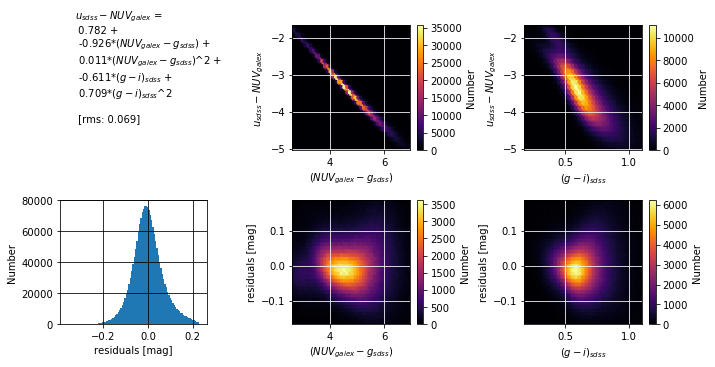

In [20]:
# Create names for use in QA plots...
dmagName = '$u_{sdss} - NUV_{galex}$'
colorLabel1 = '$(NUV_{galex} - g_{sdss})$'
colorLabel2 = '$(g-i)_{sdss}$'

# Grab the original version of df from the backup copy...
df = df_orig.copy()

# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

# Iterate, with sigma-clipping...
for i in range(niter):

    iiter = i + 1
    if verbose > 0:
        print """   iter%d...""" % ( iiter )

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag, color1, and color2 series...
    dmag =  df.loc[:,'uNUV']
    color1 = df.loc[:,'NUVg']
    color2 = df.loc[:,'gi_sdss']

    # Perform fit...
    p,perr,rms = transformFit2(color1, color2, dmag, norder, verbose)
    df.loc[:,'res'] = residuals2(p, color1, color2, dmag)

    # Identify outliers...
    stddev = df['res'].std()
    mask = (np.abs(df.res)< nsigma*stddev)
    
outputLine = createFitResultsOutputLine(norder, p, perr, rms, 'uNUV', 'NUVg', 'gi_sdss')
#fout.write(outputLine+'\n')
if verbose > 0:
    print outputLine
    print 

# Create QA plots...
res =  df.loc[:,'res']
outputFileName = """%s.%s.%s.%s.qa1.png""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
status = transform2ColorQAPlots1(dmag, color1, color2, res, norder, dmagName, 
                                          colorLabel1, colorLabel2, p, rms, outputFileName)

#outputFileName = """%s.%s.%s.%s.qa2.html""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
#status = sdssGalexTransform2ColorQAPlots2(df, 'uNUV', 'NUVg', 'gi_sdss', 'res', dmagName, colorLabel1, colorLabel2, norder, p, rms, outputFileName)

#outputFileName = """%s.%s.%s.%s.qa3_res.html""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
#status = sdssGalexTransform2ColorQAPlots3(df, 'uNUV', 'NUVg', 'gi_sdss', 'res', dmagName, colorLabel1, colorLabel2, norder, p, rms, outputFileName)

# Apply fit...
df.loc[:,'u_est_sdss_1'] = df.loc[:,'NUV_galex'] + fp2(p, color1, color2)

In [21]:
df.head(10)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,iz_sdss,gi_sdss,uNUV,NUVg,NUVG,FUVNUV,absGLAT,dmag,res,u_est_sdss_1
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,0.105635,0.649585,-3.006222,4.161612,4.634053,NaN,47.9766,-9999.0,-0.026669,17.298747
5,SDSS J000000.11+215551.8,0.000479,21.931072,15.829166,14.694019,14.283171,14.154482,14.106201,0.017856,0.013601,...,0.048281,0.539537,-2.987534,4.122681,4.529603,NaN,39.3882,-9999.0,-0.014971,15.844138
12,SDSS J000000.25+272252.8,0.001074,27.381337,16.911947,15.463360,14.949074,14.852628,14.804597,0.013028,0.013314,...,0.048031,0.610732,-3.845953,5.294540,5.760880,NaN,34.1078,-9999.0,0.076857,16.835090
14,SDSS J000000.34-070104.7,0.001438,-7.017989,18.247087,17.245728,16.863420,16.712297,16.641680,0.016953,0.018778,...,0.070618,0.533430,-2.301113,3.302473,3.689164,NaN,66.4743,-9999.0,-0.020677,18.267764
15,SDSS J000000.35+154825.4,0.001493,15.807069,18.438923,17.008329,16.430065,16.229681,16.153006,0.018856,0.016941,...,0.076675,0.778648,-4.342978,5.773571,6.286434,NaN,45.2874,-9999.0,-0.097193,18.536116
17,SDSS J000000.40+273438.5,0.001703,27.577365,17.554903,16.194595,15.678644,15.532434,15.471504,0.017657,0.013331,...,0.060929,0.662162,-3.117496,4.477804,4.954460,NaN,33.9177,-9999.0,0.121041,17.433862
29,SDSS J000000.55+262543.8,0.002321,26.428843,16.890472,15.496163,15.015032,14.792026,14.711613,0.015227,0.013377,...,0.080413,0.704138,-4.137827,5.532136,6.032524,NaN,35.0322,-9999.0,-0.053050,16.943523
30,SDSS J000000.56+002529.8,0.002371,0.424960,16.987377,15.811518,15.373553,15.239797,15.187872,0.018664,0.020790,...,0.051925,0.571721,-3.624422,4.800282,5.209230,NaN,59.7991,-9999.0,-0.096034,17.083412
31,SDSS J000000.57+144005.0,0.002390,14.668082,16.886185,15.212828,14.629071,14.449692,14.403210,0.010456,0.013569,...,0.046482,0.763136,-4.235016,5.908373,6.442292,NaN,46.3798,-9999.0,0.125917,16.760267
38,SDSS J000000.63+044905.0,0.002665,4.818061,17.103626,15.616484,15.060987,14.919496,14.825769,0.014523,0.013868,...,0.093726,0.696988,-4.010473,5.497616,6.007943,NaN,55.7216,-9999.0,0.049222,17.054405


## Run (u_sdss-NUV) vs. (NUV-G) and (BP-RP) fit

   iter1...

Initial parameter values:   [-3.4765024, 0.0, 0.0, 0.0, 0.0]
Converged
Converged with chi squared  20544.121674632377
degrees of freedom, dof  1914365
RMS of residuals (i.e. sqrt(chisq/dof))  0.103593240036
Reduced chisq (i.e. variance of residuals)  0.010731559381117172

Fitted parameters at minimum, with 68% C.I.:
c_0             0.589045 +/-    0.00104606   (0.177586 percent)
c_1            -0.765915 +/-   0.000532031   (0.069463 percent)
c_2          -0.00316007 +/-   5.01694e-05   (1.587602 percent)
c_3            -0.927039 +/-    0.00305236   (0.329259 percent)
c_4              1.10131 +/-    0.00172876   (0.156973 percent)

Correlation matrix:
                c_0        c_1        c_2        c_3        c_4       
c_0          1.000000
c_1         -0.391277   1.000000
c_2          0.405656  -0.968426   1.000000
c_3         -0.358554  -0.702011   0.660938   1.000000
c_4          0.312622   0.652126  -0.680248  -0.946793   1.000000



   iter2...

Initial parameter val

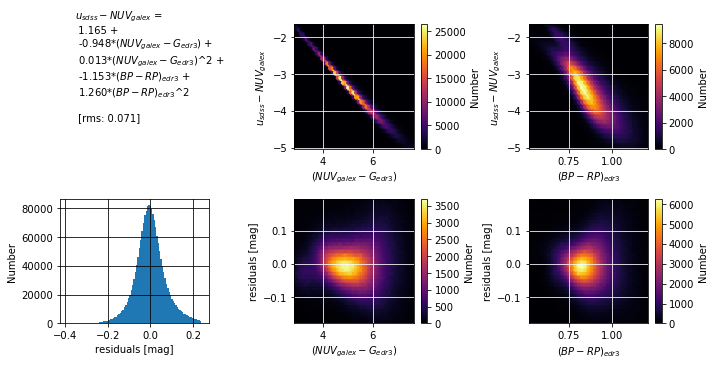

In [22]:
# Create names for use in QA plots...
dmagName = '$u_{sdss} - NUV_{galex}$'
colorLabel1 = '$(NUV_{galex} - G_{edr3})$'
colorLabel2 = '$(BP-RP)_{edr3}$'

# Grab the original version of df from the backup copy...
df = df_orig.copy()

# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

# Iterate, with sigma-clipping...
for i in range(niter):

    iiter = i + 1
    if verbose > 0:
        print """   iter%d...""" % ( iiter )

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag, color1, and color2 series...
    dmag =  df.loc[:,'uNUV']
    color1 = df.loc[:,'NUVG']
    color2 = df.loc[:,'BP_RP_gaia']

    # Perform fit...
    p,perr,rms = transformFit2(color1, color2, dmag, norder, verbose)
    df.loc[:,'res'] = residuals2(p, color1, color2, dmag)

    # Identify outliers...
    stddev = df['res'].std()
    mask = (np.abs(df.res)< nsigma*stddev)
    
outputLine = createFitResultsOutputLine(norder, p, perr, rms, 'uNUV', 'NUVG', 'BP_RP_gaia')
#fout.write(outputLine+'\n')
if verbose > 0:
    print outputLine
    print 

# Create QA plots...
res =  df.loc[:,'res']
outputFileName = """%s.%s.%s.%s.qa1.png""" % (qaFileBaseName, 'uNUV', 'NUVG', 'BP_GP_gaia')
status = transform2ColorQAPlots1(dmag, color1, color2, res, norder, dmagName, 
                                          colorLabel1, colorLabel2, p, rms, outputFileName)

#outputFileName = """%s.%s.%s.%s.qa2.html""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
#status = sdssGalexTransform2ColorQAPlots2(df, 'uNUV', 'NUVg', 'gi_sdss', 'res', dmagName, colorLabel1, colorLabel2, norder, p, rms, outputFileName)

#outputFileName = """%s.%s.%s.%s.qa3_res.html""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
#status = sdssGalexTransform2ColorQAPlots3(df, 'uNUV', 'NUVg', 'gi_sdss', 'res', dmagName, colorLabel1, colorLabel2, norder, p, rms, outputFileName)

df.loc[:,'u_est_gaia_1'] = df.loc[:,'NUV_galex'] + fp2(p, color1, color2)

In [23]:
df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,iz_sdss,gi_sdss,uNUV,NUVg,NUVG,FUVNUV,absGLAT,dmag,res,u_est_gaia_1
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,0.105635,0.649585,-3.006222,4.161612,4.634053,NaN,47.9766,-9999.0,-0.022597,17.294675
5,SDSS J000000.11+215551.8,0.000479,21.931072,15.829166,14.694019,14.283171,14.154482,14.106201,0.017856,0.013601,...,0.048281,0.539537,-2.987534,4.122681,4.529603,NaN,39.3882,-9999.0,0.015295,15.813871
12,SDSS J000000.25+272252.8,0.001074,27.381337,16.911947,15.463360,14.949074,14.852628,14.804597,0.013028,0.013314,...,0.048031,0.610732,-3.845953,5.294540,5.760880,NaN,34.1078,-9999.0,0.076462,16.835485
14,SDSS J000000.34-070104.7,0.001438,-7.017989,18.247087,17.245728,16.863420,16.712297,16.641680,0.016953,0.018778,...,0.070618,0.533430,-2.301113,3.302473,3.689164,NaN,66.4743,-9999.0,-0.004910,18.251998
15,SDSS J000000.35+154825.4,0.001493,15.807069,18.438923,17.008329,16.430065,16.229681,16.153006,0.018856,0.016941,...,0.076675,0.778648,-4.342978,5.773571,6.286434,NaN,45.2874,-9999.0,-0.098903,18.537826


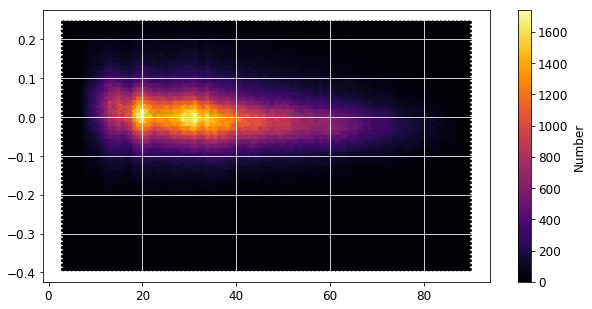

In [24]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10,5))
absglat = df.loc[:,'absGLAT']
hb=plt.hexbin(absglat, res, gridsize=100, cmap='inferno')
#plt.axis([color1_min, color1_max, dmag_min, dmag_max])
#plt.xlabel(colorLabel1)
#plt.ylabel(dmagName)
cb = fig.colorbar(hb)
cb.set_label('Number')
plt.grid(color='white')
plt.grid(True)


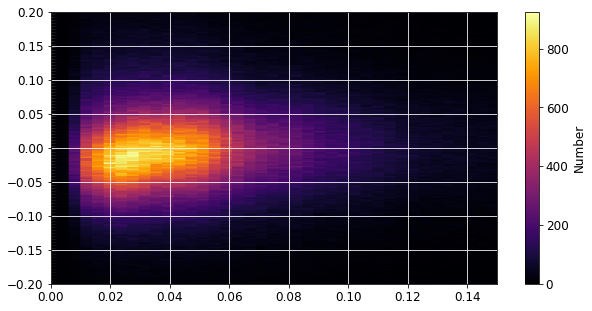

In [25]:
fig = plt.figure(figsize=(10,5))
ebv = df.loc[:,'E_BV']
hb=plt.hexbin(ebv, res, gridsize=500, cmap='inferno')
plt.axis([0.00, 0.15, -0.2, 0.2])
#plt.xlabel(colorLabel1)
#plt.ylabel(dmagName)
cb = fig.colorbar(hb)
cb.set_label('Number')
plt.grid(color='white')
plt.grid(True)


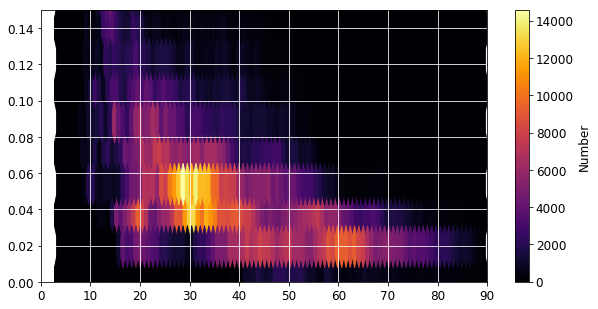

In [26]:
fig = plt.figure(figsize=(10,5))
ebv = df.loc[:,'E_BV']
absglat = df.loc[:,'absGLAT']
hb=plt.hexbin(absglat, ebv, gridsize=100, cmap='inferno')
plt.axis([0.00, 90.00, 0.00, 0.15])
#plt.xlabel(colorLabel1)
#plt.ylabel(dmagName)
cb = fig.colorbar(hb)
cb.set_label('Number')
plt.grid(color='white')
plt.grid(True)

In [27]:
# From Zeljko Ivezic:
# Robust estimate of standard deviation: 0.741*(q75-q25)
#  sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
# Uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#  sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])

def robustStdDev(data):
    sd = 0.741*(np.percentile(data,75)-np.percentile(data,25))
    return sd

def uncMedian(data, npts):
    sd = robustStdDev(data)
    uncMedian = np.sqrt(np.pi/2)*sd/np.sqrt(npts)
    return uncMedian

In [28]:
for c in df.columns:
    print c

name_in
RA_sdss
DEC_sdss
u_sdss
g_sdss
r_sdss
i_sdss
z_sdss
uerr_sdss
gerr_sdss
rerr_sdss
ierr_sdss
zerr_sdss
run
stripe
RAJ2000
DEJ2000
name_cds
objid
phID
Cat
RAfdeg
DEfdeg
FUVexp
NUVexp
GLON
GLAT
tile
img
sv
r.fov
Obs
b
E_BV
Sp?
chkf
FUV_galex
FUVerr_galex
NUV_galex
NUVerr_galex
FUV.a
e_FUV.a
NUV.a
e_NUV.a
FUV.4
e_FUV.4
NUV.4
e_NUV.4
FUV.6
e_FUV.6
NUV.6
e_NUV.6
Fafl
Nafl
Fexf
Nexf
Fflux
e_Fflux
Nflux
e_Nflux
FXpos
FYpos
NXpos
NYpos
Fima
Nima
Fr
Nr
nS/G
fS/G
nell
fell
nPA
e_nPA
fPA
e_fPA
Fnr
F3r
Nar
Narms
Nbrms
Far
Farms
Fbrms
w_NUV
w_FUV
Prob
Sep
Nerr
Ferr
Ierr
Nperr
Fperr
CV
G
N
primid
groupid
Gd
Nd
primidd
groupidd
grouptot
OName
Size
angDist_in
ra_epoch2000
dec_epoch2000
errHalfMaj
errHalfMin
errPosAng
source_id
ra_cds
ra_error
dec_cds
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
astrometric_n_good_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
pseudocolour

In [29]:
# Identify x and y series...

# x is absGLAT:
x_name = 'absGLAT'
x_min = 5.00
x_max = 90.00
x_binsize = 5.00

# x is E_BV:
#x_name = 'E_BV'
#x_min = 0.00
#x_max = 0.15
#x_binsize = 0.01

## x is NUV:
#x_name = 'NUV_galex'
#x_min = 17.0
#x_max = 23.0
#x_binsize = 1.0

# y is res:
y_name = 'res'
x = df.loc[:,x_name]
y = df.loc[:,y_name]



# Calculate the x range to bin and the number of bins, 
#  based on the 0.01%-99.99% color range...
#x_desc = df[x_name].describe(percentiles=[0.0001, 0.9999])
#x_min = math.floor(10*x_desc['0.01%'])/10.
#x_max = math.ceil(10*x_desc['99.99%'])/10.
if verbose>1:
    print 
    #print x_desc
    print x_min, x_max 
    print 
#binsize = x_binsize
ranges = np.arange(x_min,x_max+x_binsize,x_binsize)
# Label the bins by their mid-point...
labels = np.arange(x_min,x_max,x_binsize) + 0.5*x_binsize
    
if verbose:
    print ranges
    print labels
    
# Bin the data, adding "bin_interval" and "bin_label' to the df dataframe...
df['bin_interval'] = pd.cut(df[x_name], bins=ranges, precision=0)
df['bin_label'] = pd.cut(df[x_name], bins=ranges, labels=labels)
if verbose>1:
    print 
    print df[[x_name,'bin_interval','bin_label']].head()
    print 

# Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
df_grp = df.groupby(['bin_label'])
bin_interval = df_grp['bin_interval'].first()
y_num = df_grp[y_name].count()
y_mean = df_grp[y_name].mean()
y_sd = df_grp[y_name].std()
y_err = y_sd/np.sqrt(y_num-1)
y_median = df_grp[y_name].median()
y_rsd = df_grp[y_name].apply(robustStdDev)
y_unc = np.sqrt(np.pi/2)*y_rsd/np.sqrt(y_num)

# Rename some of the pandas series...
y_num.name    = 'bin_num'
y_mean.name   = 'bin_mean'
y_sd.name     = 'bin_stddev'
y_err.name    = 'bin_stderr'
y_median.name = 'bin_median'
y_rsd.name    = 'bin_rstddev'
y_unc.name    = 'bin_unc'
    
# Create new data frame containing all the relevant aggregate quantities...
df1 = pd.concat( [bin_interval, y_num, \
                  y_mean, y_sd, y_err, \
                  y_median, y_rsd, y_unc, ], \
                join='outer', axis=1 )
    
if verbose>1:
    print 
    print df1
    print 
    
    
# Create results output file...
#resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
#df1.to_csv(resultsFile)
#if verbose>1:
#    print """Writing binned values to %s""" % (resultsFile)

    
# Create name for QA plot output file...
#outputFileName = """qaPlot_%s.%s_%s.png""" % (resultsFileBaseName, band, color_name_1)


# Apply results...
response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    
df.loc[:,'u_est_gaia_2'] = df.loc[:,'u_est_gaia_1'] + response(df[x_name].values)


5.0 90.0

[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85. 90.]
[ 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 52.5 57.5 62.5 67.5 72.5
 77.5 82.5 87.5]

    absGLAT bin_interval bin_label
1   47.9766     (45, 50]      47.5
5   39.3882     (35, 40]      37.5
12  34.1078     (30, 35]      32.5
14  66.4743     (65, 70]      67.5
15  45.2874     (45, 50]      47.5


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
7.5            (5, 10]    27219  0.021009    0.092960    0.000563    0.023108   
12.5          (10, 15]   123832  0.016754    0.078923    0.000224    0.019062   
17.5          (15, 20]   183510  0.009269    0.070728    0.000165    0.009601   
22.5          (20, 25]   204721  0.005382    0.070256    0.000155    0.004641   
27.5          (25, 30]   210865  0.003984    0.069608    0.000152    0.001894   
32.5          (30, 35]   222008  0.002536    0.

In [30]:
df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,NUVg,NUVG,FUVNUV,absGLAT,dmag,res,u_est_gaia_1,bin_interval,bin_label,u_est_gaia_2
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,4.161612,4.634053,NaN,47.9766,-9999.0,-0.022597,17.294675,"(45, 50]",47.5,17.284554
5,SDSS J000000.11+215551.8,0.000479,21.931072,15.829166,14.694019,14.283171,14.154482,14.106201,0.017856,0.013601,...,4.122681,4.529603,NaN,39.3882,-9999.0,0.015295,15.813871,"(35, 40]",37.5,15.807154
12,SDSS J000000.25+272252.8,0.001074,27.381337,16.911947,15.463360,14.949074,14.852628,14.804597,0.013028,0.013314,...,5.294540,5.760880,NaN,34.1078,-9999.0,0.076462,16.835485,"(30, 35]",32.5,16.833417
14,SDSS J000000.34-070104.7,0.001438,-7.017989,18.247087,17.245728,16.863420,16.712297,16.641680,0.016953,0.018778,...,3.302473,3.689164,NaN,66.4743,-9999.0,-0.004910,18.251998,"(65, 70]",67.5,18.234493
15,SDSS J000000.35+154825.4,0.001493,15.807069,18.438923,17.008329,16.430065,16.229681,16.153006,0.018856,0.016941,...,5.773571,6.286434,NaN,45.2874,-9999.0,-0.098903,18.537826,"(45, 50]",47.5,18.528736


In [31]:
#df.to_csv('/data/des40.a/data/dtucker/SDSS/SDSSDR16_dtucker_all_sorted_test.csv', index=False)

In [32]:
## From Section 3.3 of http://ehneilsen.net/notebook/pandasExamples/pandas_examples.html...
##  (Eric Neilsen's very useful list of Pandas astro examples)
#result_file = fitsio.FITS('/data/des40.a/data/dtucker/SDSS/SDSSDR16_dtucker_all_sorted_test.fits', 'rw')
#result_file.write(df.to_records(index=False))
#result_file.close()


In [33]:
#t = Table.from_pandas(df)
#t

In [34]:
#t.write('/data/des40.a/data/dtucker/SDSS/SDSSDR16_dtucker_all_sorted_plus.fit', overwrite=True)

<Container object of 3 artists>

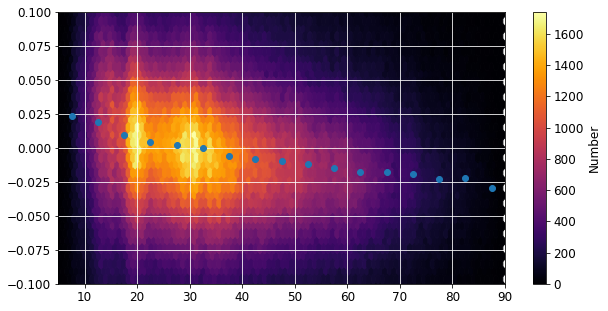

In [35]:
#plt.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(10,5))
x = df.loc[:,x_name]
hb=plt.hexbin(x, res, gridsize=100, cmap='inferno')
#hb=plt.hexbin(x, res, gridsize=100, bins='log', cmap='inferno')
plt.axis([x_min, x_max, -0.10, 0.10])
#plt.xlabel(colorLabel1)
#plt.ylabel(dmagName)
cb = fig.colorbar(hb)
cb.set_label('Number')
#cb.set_label('log10(N)')
plt.grid(color='white')
plt.grid(True)
# Overplot the binned values calculated above:
plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, fmt='o')


In [36]:
(-0.030-0.000)/(90.-30.)

-0.0005

## Run (u_sdss-NUV) vs. (NUV-G), (BP-RP), and abs(Galactic Latitude) fit...

In [37]:
# Create names for use in QA plots...
dmagName = '$u_{sdss} - NUV_{galex}$'
colorLabel1 = '$(NUV_{galex} - G_{edr3})$'
colorLabel2 = '$(BP-RP)_{edr3}$'
absglatLabel = '$abs(GLAT)$'

# Grab the original version of df from the backup copy...
df = df_orig.copy()

# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

# Iterate, with sigma-clipping...
for i in range(niter):

    iiter = i + 1
    if verbose > 0:
        print """   iter%d...""" % ( iiter )

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag, color1, and color2 series...
    dmag =  df.loc[:,'uNUV']
    color1 = df.loc[:,'NUVG']
    color2 = df.loc[:,'BP_RP_gaia']
    absglat = df.loc[:,'absGLAT']

    # Perform fit...
    p,perr,rms = transformFit2glat(color1, color2, absglat, dmag, norder, verbose)
    df.loc[:,'res'] = residuals2glat(p, color1, color2, absglat, dmag)

    # Identify outliers...
    stddev = df['res'].std()
    mask = (np.abs(df.res)< nsigma*stddev)
    
#outputLine = createFitResultsOutputLineGlat(norder, p, perr, rms, 'uNUV', 'NUVG', 'BP_RP_gaia', 'absGLAT')
#fout.write(outputLine+'\n')
if verbose > 0:
    print outputLine
    print 

# Create QA plots...
res =  df.loc[:,'res']
outputFileName = """%s.%s.%s.%s.%s.qa1.png""" % (qaFileBaseName, 'uNUV', 'NUVG', 'BP_GP_gaia', 'abs_glat')
status = transform2ColorQAPlots1glat(dmag, color1, color2, glat, res, norder, dmagName, 
                                          colorLabel1, colorLabel2, glatLabel, p, rms, outputFileName)

#outputFileName = """%s.%s.%s.%s.qa2.html""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
#status = sdssGalexTransform2ColorQAPlots2(df, 'uNUV', 'NUVg', 'gi_sdss', 'res', dmagName, colorLabel1, colorLabel2, norder, p, rms, outputFileName)

#outputFileName = """%s.%s.%s.%s.qa3_res.html""" % (qaFileBaseName, 'uNUV', 'NUVg', 'gi_sdss')
#status = sdssGalexTransform2ColorQAPlots3(df, 'uNUV', 'NUVg', 'gi_sdss', 'res', dmagName, colorLabel1, colorLabel2, norder, p, rms, outputFileName)


   iter1...

Initial parameter values:   [-3.4765024, 0.0, 0.0, 0.0, 0.0, 0.0]


TypeError: residuals2() takes exactly 4 arguments (5 given)

## Try Multidimensional Binning...

In [38]:
# Grab the original version of df from the backup copy...
df = df_orig.copy()

count    5.991002e+06
mean    -2.828320e+00
std      1.104833e+00
min     -6.693468e+00
1%      -4.883726e+00
50%     -2.982025e+00
99%      8.898727e-02
max      9.425631e+00
Name: uNUV, dtype: float64

count    5.990942e+06
mean     4.441272e+00
std      1.515889e+00
min     -7.755172e+00
1%       3.131992e-01
50%      4.615951e+00
99%      7.455268e+00
max      1.055536e+01
Name: NUVG, dtype: float64

count    5.984482e+06
mean     8.435945e-01
std      2.136258e-01
min     -4.776096e+00
1%       1.791876e-01
50%      8.442560e-01
99%      1.418345e+00
max      5.659645e+00
Name: BP_RP_gaia, dtype: float64



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b57d5a06590>]],
      dtype=object)

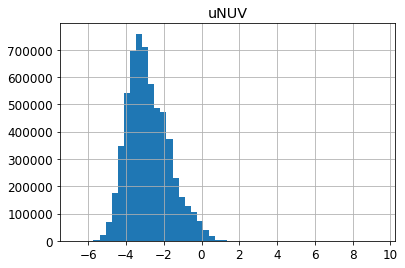

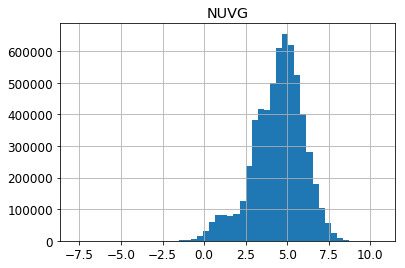

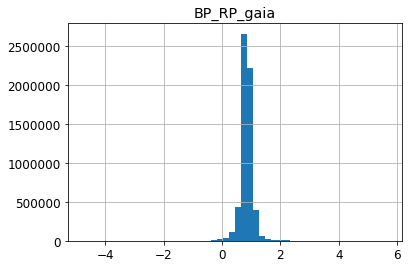

In [39]:
print df['uNUV'].describe(percentiles=[0.01, 0.50, 0.99])
print
print df['NUVG'].describe(percentiles=[0.01, 0.50, 0.99])
print
print df['BP_RP_gaia'].describe(percentiles=[0.01, 0.50, 0.99])
print

df.hist('uNUV', bins=50) # -4.8 --> 0.0
df.hist('NUVG', bins=50) # -0.2 --> 7.4
df.hist('BP_RP_gaia', bins=50) # 0.2 --> 1.4

In [40]:
# Create new mask...
uNUV_min = -4.8
uNUV_max =  0.0
NUVG_min = -0.2
NUVG_max =  7.4
BP_RP_gaia_min = 0.2
BP_RP_gaia_max = 1.4
absGLAT_min = 15.
absGLAT_max = 90.



mask_orig = ( ( df['uNUV'] > uNUV_min ) & ( df['uNUV'] < uNUV_max )       &
              ( df['NUVG'] > NUVG_min ) & ( df['NUVG'] < NUVG_max )       &
              ( df['BP_RP_gaia'] > BP_RP_gaia_min ) & ( df['BP_RP_gaia'] < BP_RP_gaia_max )      &
              ( np.abs(df['GLAT']) > absGLAT_min ) & ( np.abs(df['BP_RP_gaia']) < absGLAT_max )      &
              ( df['uerr_sdss'] < 0.02 ) )

In [41]:
# Grab the original version of df from the backup copy...
df = df_orig.copy()

In [42]:
# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

In [43]:
# make a copy of original df, overwriting the old one...
df = df[mask].copy()

In [44]:
from scipy.stats import binned_statistic_dd

In [45]:
df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,gr_sdss,ri_sdss,iz_sdss,gi_sdss,uNUV,NUVg,NUVG,FUVNUV,absGLAT,dmag
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,0.464801,0.184784,0.105635,0.649585,-3.006222,4.161612,4.634053,NaN,47.9766,-9999.0
5,SDSS J000000.11+215551.8,0.000479,21.931072,15.829166,14.694019,14.283171,14.154482,14.106201,0.017856,0.013601,...,0.410849,0.128689,0.048281,0.539537,-2.987534,4.122681,4.529603,NaN,39.3882,-9999.0
12,SDSS J000000.25+272252.8,0.001074,27.381337,16.911947,15.463360,14.949074,14.852628,14.804597,0.013028,0.013314,...,0.514286,0.096446,0.048031,0.610732,-3.845953,5.294540,5.760880,NaN,34.1078,-9999.0
14,SDSS J000000.34-070104.7,0.001438,-7.017989,18.247087,17.245728,16.863420,16.712297,16.641680,0.016953,0.018778,...,0.382307,0.151123,0.070618,0.533430,-2.301113,3.302473,3.689164,NaN,66.4743,-9999.0
15,SDSS J000000.35+154825.4,0.001493,15.807069,18.438923,17.008329,16.430065,16.229681,16.153006,0.018856,0.016941,...,0.578264,0.200384,0.076675,0.778648,-4.342978,5.773571,6.286434,NaN,45.2874,-9999.0


count    1.689513e+06
mean    -3.413988e+00
std      6.987486e-01
min     -4.799992e+00
1%      -4.701847e+00
50%     -3.463264e+00
99%     -1.615536e+00
max     -5.874634e-04
Name: uNUV, dtype: float64
count    1.689513e+06
mean     5.161455e+00
std      9.798648e-01
min     -1.986838e-01
1%       2.808855e+00
50%      5.186303e+00
99%      7.123665e+00
max      7.399966e+00
Name: NUVG, dtype: float64
count    1.689513e+06
mean     8.657608e-01
std      1.233827e-01
min      2.000290e-01
1%       5.236340e-01
50%      8.615030e-01
99%      1.168659e+00
max      1.399856e+00
Name: BP_RP_gaia, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b57d6be9490>]],
      dtype=object)

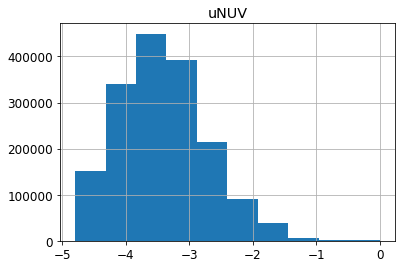

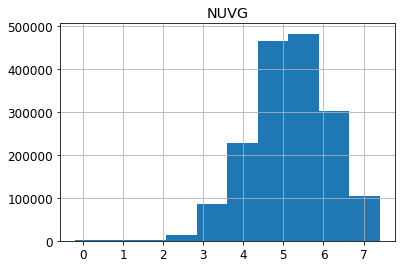

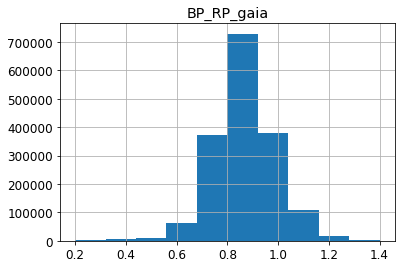

In [46]:
print df['uNUV'].describe(percentiles=[0.01, 0.50, 0.99])
print df['NUVG'].describe(percentiles=[0.01, 0.50, 0.99])
print df['BP_RP_gaia'].describe(percentiles=[0.01, 0.50, 0.99])

df.hist('uNUV') # -4.9 --> -1.8
df.hist('NUVG') # -0.2 --> 1.2
df.hist('BP_RP_gaia') # 0.6 --> 1.1

In [47]:
nuvg_bins = np.linspace(2.8, 6.8, 21)
print nuvg_bins
print 

bprp_bins = np.linspace(0.6, 1.1, 21)
print bprp_bins
print 

absglat_bins = np.linspace(10.0, 90., 17)
print absglat_bins
print

[2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2
 6.4 6.6 6.8]

[0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1  ]

[10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85. 90.]



In [48]:
#(np.array([p1, p2, p3]))





In [49]:
#Maybe use pandas groupby function to bin things in multiple dimensions.
# Then use RegularGridInterpolator to apply the N-dimensional linear interpolation:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator

In [50]:
df.head(5)

,name_in,RA_sdss,DEC_sdss,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,uerr_sdss,gerr_sdss,...,gr_sdss,ri_sdss,iz_sdss,gi_sdss,uNUV,NUVg,NUVG,FUVNUV,absGLAT,dmag
1,SDSS J000000.02+125954.1,0.000094,12.998368,17.272078,16.116688,15.651887,15.467103,15.361468,0.019288,0.018229,...,0.464801,0.184784,0.105635,0.649585,-3.006222,4.161612,4.634053,NaN,47.9766,-9999.0
5,SDSS J000000.11+215551.8,0.000479,21.931072,15.829166,14.694019,14.283171,14.154482,14.106201,0.017856,0.013601,...,0.410849,0.128689,0.048281,0.539537,-2.987534,4.122681,4.529603,NaN,39.3882,-9999.0
12,SDSS J000000.25+272252.8,0.001074,27.381337,16.911947,15.463360,14.949074,14.852628,14.804597,0.013028,0.013314,...,0.514286,0.096446,0.048031,0.610732,-3.845953,5.294540,5.760880,NaN,34.1078,-9999.0
14,SDSS J000000.34-070104.7,0.001438,-7.017989,18.247087,17.245728,16.863420,16.712297,16.641680,0.016953,0.018778,...,0.382307,0.151123,0.070618,0.533430,-2.301113,3.302473,3.689164,NaN,66.4743,-9999.0
15,SDSS J000000.35+154825.4,0.001493,15.807069,18.438923,17.008329,16.430065,16.229681,16.153006,0.018856,0.016941,...,0.578264,0.200384,0.076675,0.778648,-4.342978,5.773571,6.286434,NaN,45.2874,-9999.0


In [51]:
# f is uNUV
f_name = 'uNUV'

# x is NUV-G:
x_name = 'NUVG'
x_min = NUVG_min
x_max = NUVG_max
#x_min = df[x_name].min()
#x_max = df[x_name].max()
x_binsize = 0.20
x_nbins = int((x_max-x_min)/x_binsize) + 1
print(x_nbins, x_min, x_max)

# y is BP-RP
y_name = 'BP_RP_gaia'
y_min = BP_RP_gaia_min
y_max = BP_RP_gaia_max
#y_min = df[y_name].min()
#y_max = df[y_name].max()
y_binsize = 0.02
y_nbins = int((y_max-y_min)/y_binsize) + 1
print(y_nbins, y_min, y_max)

# z is |GLAT|:
z_name = 'absGLAT'
z_min = absGLAT_min
z_max = absGLAT_max
#z_min = df[z_name].min()
#z_max = df[z_name].max()
z_binsize = 5.00
z_nbins = int((z_max-z_min)/z_binsize) + 1
print(z_nbins, z_min, z_max)



(39, -0.2, 7.4)
(61, 0.2, 1.4)
(16, 15.0, 90.0)


In [52]:
nuvg_bins = np.linspace(x_min, x_max, x_nbins)
print nuvg_bins
print 

bprp_bins = np.linspace(y_min, y_max, y_nbins)
print bprp_bins
print 

absglat_bins = np.linspace(z_min, z_max, z_nbins)
print absglat_bins
print

# x is NUV-g:
x_name = 'NUVg'
x_min = NUVG_min
x_max = NUVG_max
#x_min = df[x_name].min()
#x_max = df[x_name].max()
x_binsize = 0.20

# y is BP-RP
y_name = 'BP_RP_gaia'
y_min = BP_RP_gaia_min
y_max = BP_RP_gaia_max
#y_min = df[y_name].min()
#y_max = df[y_name].max()
y_binsize = 0.02

# z is |GLAT|:
z_name = 'absGLAT'
z_min = absGLAT_min
z_max = absGLAT_max
#z_min = df[z_name].min()
#z_max = df[z_name].max()
z_binsize = 10.00

# We want to fit the (binned) function f=f(x,y,z)
f = df.loc[:,'uNUV']
x = df.loc[:,x_name]
y = df.loc[:,y_name]
z = df.loc[:,z_name]

# Create ranges in x, y, z...
x_ranges = np.arange(x_min,x_max+x_binsize,x_binsize)
y_ranges = np.arange(y_min,y_max+y_binsize,y_binsize)
z_ranges = np.arange(z_min,z_max+z_binsize,z_binsize)

# Label the bins by their mid-point...
x_labels = np.arange(x_min,x_max,x_binsize) + 0.5*x_binsize
y_labels = np.arange(y_min,y_max,y_binsize) + 0.5*y_binsize
z_labels = np.arange(z_min,z_max,z_binsize) + 0.5*z_binsize

if verbose:
    print x_ranges
    print x_labels
    print y_ranges
    print y_labels
    print z_ranges
    print z_labels

    
# Bin the data in each dimension (i.e. in x,y,z)...
df['x_bin_interval'] = pd.cut(df[x_name], bins=x_ranges, precision=3)
df['y_bin_interval'] = pd.cut(df[y_name], bins=y_ranges, precision=3)
df['z_bin_interval'] = pd.cut(df[z_name], bins=z_ranges, precision=3)

# Create labels for each dimension... 
df['x_bin_label'] = pd.cut(df[x_name], bins=x_ranges, labels=x_labels)
df['y_bin_label'] = pd.cut(df[y_name], bins=y_ranges, labels=y_labels)
df['z_bin_label'] = pd.cut(df[z_name], bins=z_ranges, labels=z_labels)

# Create an ueber-label for each 3D bin...
df['3d_bin_label'] = 1000000*(1+(df[x_name]-x_min)/x_binsize).astype(int) + \
                     1000*(1+(df[y_name]-y_min)/y_binsize).astype(int) + \
                     1*(1+(df[z_name]-z_min)/z_binsize).astype(int)

if verbose>1:
    print 
    print df[[x_name,'x_bin_interval','x_bin_label',
              y_name,'y_bin_interval','y_bin_label',
              z_name,'z_bin_interval','z_bin_label','3d_bin_label']].head(20)
    print 

    
    





[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4
  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2
  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4]

[0.2  0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46
 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74
 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02
 1.04 1.06 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3
 1.32 1.34 1.36 1.38 1.4 ]

[15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85. 90.]

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4
  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2
  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4]
[-0.1  0.1  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5
  2.7  2.9  3.1  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3
  5.5  5.7  5.9  6.1  6.3  6.5  6.7  6.9  7.1  7.3]
[0.2  0.22 0.24 0.26 0.28 0.3

In [53]:
# Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
df_grp = df.groupby(['3d_bin_label'])
f_3d_bin_label = df_grp['3d_bin_label'].first()

f_x = df_grp['x_bin_label'].first()
f_y = df_grp['y_bin_label'].first()
f_z = df_grp['z_bin_label'].first()


#bin_interval = df_grp['bin_interval'].first()
f_num = df_grp[f_name].count()
f_mean = df_grp[f_name].mean()
f_sd = df_grp[f_name].std()
f_err = f_sd/np.sqrt(f_num-1)
f_median = df_grp[f_name].median()
f_rsd = df_grp[f_name].apply(robustStdDev)
f_unc = np.sqrt(np.pi/2)*f_rsd/np.sqrt(f_num)

# Rename some of the pandas series...
f_x.name      = x_name
f_y.name      = y_name
f_z.name      = z_name
f_num.name    = 'bin_num'
f_mean.name   = 'bin_mean'
f_sd.name     = 'bin_stddev'
f_err.name    = 'bin_stderr'
f_median.name = 'bin_median'
f_rsd.name    = 'bin_rstddev'
f_unc.name    = 'bin_unc'
    
# Create new data frame containing all the relevant aggregate quantities...
df1 = pd.concat( [f_3d_bin_label, f_x, f_y, f_z, f_num, \
                  f_mean, f_sd, f_err, \
                  f_median, f_rsd, f_unc, ], \
                join='outer', axis=1 )
    
if verbose>1:
    print 
    print df1
    print 
    
    


              3d_bin_label  NUVg  BP_RP_gaia  absGLAT  bin_num  bin_mean  \
3d_bin_label                                                               
18003                18003   NaN        0.55     40.0        1 -0.133572   
22003                22003   NaN        0.63     40.0        1 -0.541473   
1010006            1010006  -0.1        0.39     70.0        1 -0.396355   
1019006            1019006  -0.1        0.57     70.0        1 -0.001984   
1025006            1025006  -0.1        0.69     70.0        1 -0.067329   
2001001            2001001   0.1        0.21     20.0        1 -0.014894   
2003001            2003001   0.1        0.25     20.0        1 -0.047293   
2003005            2003005   0.1        0.25     60.0        1 -0.048859   
2004004            2004004   0.1        0.27     50.0        1 -0.085064   
2005002            2005002   0.1        0.29     30.0        2 -0.068908   
2006002            2006002   0.1        0.31     30.0        1 -0.021191   
2006003    

In [54]:
df1.describe()

,3d_bin_label,NUVg,BP_RP_gaia,absGLAT,bin_num,bin_mean,bin_stddev,bin_stderr,bin_median,bin_rstddev,bin_unc
count,7.570000e+03,7568.000000,7570.000000,7570.000000,7570.000000,7570.000000,5977.000000,5977.000000,7570.000000,7570.000000,7570.000000
mean,1.911058e+07,3.517125,0.789873,50.760898,223.185337,-2.415026,0.123287,0.050277,-2.417366,0.077891,0.028894
std,9.024474e+06,1.802054,0.296542,21.076891,649.853730,1.315817,0.096209,0.086586,1.318489,0.074207,0.048087
min,1.800300e+04,-0.100000,0.210000,20.000000,1.000000,-4.797184,0.000027,0.000027,-4.797184,0.000000,0.000000
25%,1.202500e+07,2.100000,0.570000,30.000000,2.000000,-3.552188,0.070213,0.006979,-3.560368,0.023189,0.002329
50%,1.902900e+07,3.500000,0.790000,50.000000,8.000000,-2.320810,0.094619,0.019856,-2.322468,0.070514,0.012090
75%,2.702375e+07,5.100000,1.010000,70.000000,83.000000,-1.344559,0.146515,0.056812,-1.341489,0.101085,0.034577
max,3.705800e+07,7.100000,1.390000,90.000000,6436.000000,-0.000587,0.919779,0.919779,-0.000587,0.896428,0.561753


In [55]:

# Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
df_grp = df.groupby(['bin_label'])
bin_interval = df_grp['bin_interval'].first()
y_num = df_grp[y_name].count()
y_mean = df_grp[y_name].mean()
y_sd = df_grp[y_name].std()
y_err = y_sd/np.sqrt(y_num-1)
y_median = df_grp[y_name].median()
y_rsd = df_grp[y_name].apply(robustStdDev)
y_unc = np.sqrt(np.pi/2)*y_rsd/np.sqrt(y_num)

# Rename some of the pandas series...
y_num.name    = 'bin_num'
y_mean.name   = 'bin_mean'
y_sd.name     = 'bin_stddev'
y_err.name    = 'bin_stderr'
y_median.name = 'bin_median'
y_rsd.name    = 'bin_rstddev'
y_unc.name    = 'bin_unc'
    
# Create new data frame containing all the relevant aggregate quantities...
df1 = pd.concat( [bin_interval, y_num, \
                  y_mean, y_sd, y_err, \
                  y_median, y_rsd, y_unc, ], \
                join='outer', axis=1 )
    
if verbose>1:
    print 
    print df1
    print 
    
    
# Create results output file...
#resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
#df1.to_csv(resultsFile)
#if verbose>1:
#    print """Writing binned values to %s""" % (resultsFile)

    
# Create name for QA plot output file...
#outputFileName = """qaPlot_%s.%s_%s.png""" % (resultsFileBaseName, band, color_name_1)


# Apply results...
response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    
df.loc[:,'u_est_gaia_2'] = df.loc[:,'u_est_gaia_1'] + response(df[x_name].values)

KeyError: 'bin_label'

In [ ]:
import numpy as np
from scipy.stats import binned_statistic

data = np.random.rand(100)
bin_means = binned_statistic(data, data, bins=10, range=(0, 1))[0]

In [ ]:
bin_means

In [ ]:
binned_statistic(data, data, bins=10, range=(0, 1))